In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
os.getcwd()

'/home/shanks/data-science/PyTorchPractice/CNN/Image Classification'

In [2]:
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [3]:
batch_size = 4

trainset = torchvision.datasets.ImageFolder(root='Data-multiclass/train', transform=transform)
testset = torchvision.datasets.ImageFolder(root='Data-multiclass/test', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [4]:
CLASSES = ['affenpinscher', 'akita', 'corgi']
NUM_CLASSES = len(CLASSES)

class MultiClassImageClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(11 * 11 * 20, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, NUM_CLASSES)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        
        return x

In [5]:
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'

device = torch.device(dev)

In [6]:
model = MultiClassImageClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
print(model)

MultiClassImageClassifier(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2420, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [7]:
model.to(device)

MultiClassImageClassifier(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2420, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
NUM_EPOCHS = 30
loss_values = []
batch_lst = []
batches = 0
running_loss = 0.0
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 10 == 9:
            loss_values.append(running_loss / 100)
            running_loss = 0.0
            batches += 100
            batch_lst.append(batches)
            
        
    print(f'Epoch: {epoch}/{NUM_EPOCHS}, loss: {loss.item(): .4f}')


Epoch: 0/30, loss:  0.6358
Epoch: 1/30, loss:  0.7936
Epoch: 2/30, loss:  0.6272
Epoch: 3/30, loss:  0.8022
Epoch: 4/30, loss:  0.5515
Epoch: 5/30, loss:  0.5640
Epoch: 6/30, loss:  0.5516
Epoch: 7/30, loss:  0.5521
Epoch: 8/30, loss:  0.5516
Epoch: 9/30, loss:  0.7782
Epoch: 10/30, loss:  0.5515
Epoch: 11/30, loss:  0.5515
Epoch: 12/30, loss:  0.5515
Epoch: 13/30, loss:  0.5517
Epoch: 14/30, loss:  0.5517
Epoch: 15/30, loss:  0.7814
Epoch: 16/30, loss:  0.5514
Epoch: 17/30, loss:  0.5515
Epoch: 18/30, loss:  0.5515
Epoch: 19/30, loss:  0.8015
Epoch: 20/30, loss:  0.5515
Epoch: 21/30, loss:  0.5515
Epoch: 22/30, loss:  0.5520
Epoch: 23/30, loss:  0.5515
Epoch: 24/30, loss:  0.5515
Epoch: 25/30, loss:  0.5522
Epoch: 26/30, loss:  0.5514
Epoch: 27/30, loss:  0.5515
Epoch: 28/30, loss:  0.5514
Epoch: 29/30, loss:  0.5516


In [10]:
len(loss_values)

210

<Axes: >

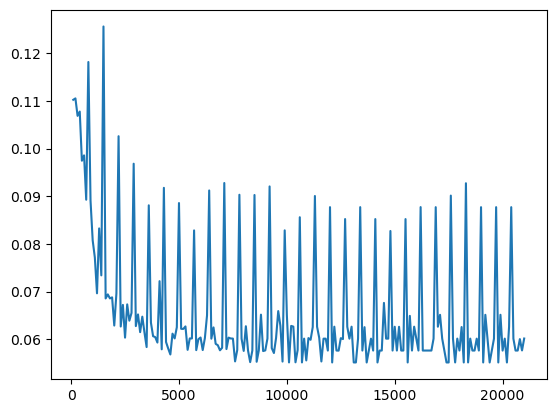

In [15]:
sns.lineplot(x=batch_lst, y=loss_values)

In [12]:
y_test = []
y_test_hat = []

for i, data in enumerate(testloader):
    inputs, y_test_temp = data
    inputs = inputs.cuda()
    y_test_temp = y_test_temp.cuda()
    
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()
        y_test_hat_temp = y_test_hat_temp.cuda()
        
    y_test.extend(y_test_temp.cpu().numpy())
    y_test_hat.extend(y_test_hat_temp.cpu().numpy())

In [13]:
acc = accuracy_score(y_test, np.argmax(y_test_hat, axis=1))
print(acc)

0.9833333333333333


<Axes: >

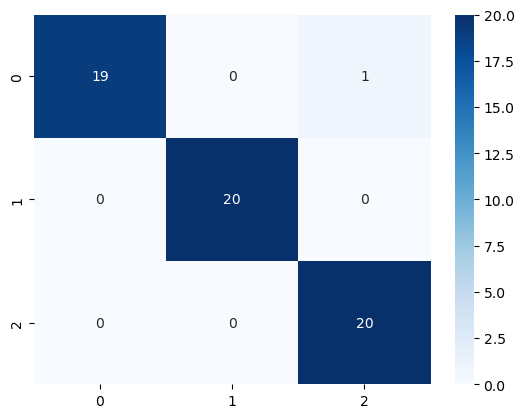

In [14]:
cm = confusion_matrix(y_test, np.argmax(y_test_hat, axis=1))
sns.heatmap(cm, annot=True, cmap='Blues')